In [51]:
#%%
import numpy as np
import scipy as sp
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime
from matplotlib import pyplot as plt
#%%
'''
    mx: mean of source with size: n x 1
    M: means of target distributions with size: n x K, where K indicates number of data-classes.
    covx: covariance matrix of source with size: n x 1
    covM: array of covariance matrices of target distributions with size: K x n x n, where K indicates number of data-classes.
    max_iter: max_iterations of Frank Wolfe
    tol: tolerance for gradient check
    divg: divergences to be used for computations
    max_iter: maximum of frank wolfe iterations
    min_tol: minimum tolerance for gardient checking
    print_iter: priniting values of maixture weights for each iteration
'''
class GM_FW:
    def __init__(self, mux, M, covx, covM, c0,  max_iter = None, min_tol = None, print_iter = None):
        # instance attributes which should be initilzied with class
        self.mux = mux
        self.M = M
        self.covx = covx
        self.covM = covM
        self.c0 = c0
        self.divg = divg
        
        self.sqrt_covx = sp.linalg.sqrtm(covx)
        print(self.sqrt_covx.shape)
        self.I = np.identity(np.size(mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(c0)
        self.mubar = np.zeros_like(mux)
        self.hat_covM = self.covM + self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]) @ self.M.T.reshape([M.shape[1], 1, M.shape[0]])
        self.tilde_covM = np.zeros_like(covM)
        self.tilde_sigma_c = np.zeros([covM.shape[1], covM.shape[2]])
        self.zeta_c = np.zeros([covM.shape[1], covM.shape[2]])
        
        if max_iter == None:
            self.max_iter = 1000
        else:
            self.max_iter = max_iter

        if min_tol == None:
            self.min_tol = 1e-6
        else:
            self.min_tol = min_tol
        
        if print_iter == None:
            self.print_iter = False
        elif print_iter == False:
            self.print_iter = False
        elif print_iter == True:
            self.print_iter = True
        else:
            self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])
    
    def reset_values(self):
        # self.mux = mux
        # self.M = M
        # self.covx = covx
        # self.covM = covM
        # self.c0 = c0
        # self.divg = divg

        self.sqrt_covx = sp.linalg.sqrtm(self.covx)
        self.I = np.identity(np.size(self.mux))

        # attributes to be keep track of computations
        self.c = np.zeros_like(self.c0)
        self.mubar = np.zeros_like(self.mux)
        self.hat_covM = self.covM + \
            self.M.T.reshape([self.M.shape[1], self.M.shape[0], 1]
                        ) @ self.M.T.reshape([self.M.shape[1], 1, self.M.shape[0]])
        self.tilde_covM = np.zeros_like(self.covM)
        self.tilde_sigma_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])
        self.zeta_c = np.zeros([self.covM.shape[1], self.covM.shape[2]])

        # if max_iter == None:
        #     self.max_iter = 1000
        # else:
        #     self.max_iter = max_iter

        # if min_tol == None:
        #     self.min_tol = 1e-6
        # else:
        #     self.min_tol = min_tol

        # if print_iter == None:
        #     self.print_iter = False
        # elif print_iter == False:
        #     self.print_iter = False
        # elif print_iter == True:
        #     self.print_iter = True
        # else:
        #     self.print_iter = False

        self.obj_vals = np.zeros([self.max_iter])
        self.grads = np.zeros([self.max_iter, np.size(self.c)])
        self.weights = np.zeros([self.max_iter, np.size(self.c)])

    def initialize_weights(self):
        self.c = self.c0

    def compute_mubar(self):
        self.mubar =  np.sum(self.c[np.newaxis,:] * self.M, axis = 1, keepdims = True)
    
    def compute_mmd(self):
        return np.linalg.norm(self.mux - self.M@self.c)**2
    
    def compute_mmd_grad(self):
        return 2*self.M.T @ (self.M @ self.c[:,np.newaxis] - self.mux)

    def compute_tilde_covM(self):
        self.tilde_covM = self.hat_covM - (self.mubar@self.mubar.T)[np.newaxis,:,:]

        
    def compute_tilde_sigma_c(self):
        self.tilde_sigma_c = np.sum(
            self.c[:, np.newaxis, np.newaxis] * self.tilde_covM, axis=0)
            
    def compute_zeta_c(self):
        temp = sp.linalg.sqrtm(self.sqrt_covx @ self.tilde_sigma_c @ self.sqrt_covx)
        self.zeta_c = (temp + temp.T)/2

    def compute_bures(self):
        temp =  np.trace( self.covx + self.tilde_sigma_c - 2 * self.zeta_c )
        return temp
    
    def compute_bures_grad_tilde_sigma_c(self):
        return self.I - self.sqrt_covx @ sp.linalg.pinv(self.zeta_c) @ self.sqrt_covx
    
    def compute_bures_grad_c(self):
        G = self.compute_bures_grad_tilde_sigma_c()
        rho = (self.M.T.reshape(self.M.shape[1], self.M.shape[0],1) @ self.mubar.T) + self.mubar @ self.M.T.reshape(self.M.shape[1],1,self. M.shape[0])
        temp = np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
        return temp
    
    def FW_Bures_routine(self):

        # commented part must be uncommented for gradient-checking
        def bures(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            zeta_ci = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            temp =  np.trace( tilde_sigma_c + self.covx  - 2 * zeta_ci )
            return temp
        
        def bures_grad(c_i):
            mubar =  np.sum(c_i[np.newaxis,:] * self.M, axis = 1, keepdims = True)
            #print("mubar")
            #print(mubar)
            #print("hat_covM")
            #print(self.hat_covM )
            #print("tilde_covM")
            tilde_covM = self.hat_covM - (mubar@mubar.T)[np.newaxis,:,:]
            #print(tilde_covM)
            tilde_sigma_c = np.sum(c_i[:, np.newaxis, np.newaxis] * tilde_covM, axis=0)
            #print("tilde_sigma_c")
            #print(tilde_sigma_c)
            temp = sp.linalg.sqrtm(self.sqrt_covx @ tilde_sigma_c @ self.sqrt_covx)
            zeta_ci = (temp + temp.T)/2
            #print("sqrt_covx")
            #print(self.sqrt_covx)
            #print("zeta_ci")
            #print(zeta_ci)
            G = self.I - self.sqrt_covx @ np.linalg.pinv(zeta_ci) @ self.sqrt_covx
            print("G")
            print(G)
            rho = (M.T.reshape(M.shape[1],M.shape[0],1) @ self.mubar.T) +  self.mubar @ M.T.reshape(M.shape[1],1,M.shape[0])
            print("rho")
            print(rho)
            return np.sum(G[np.newaxis, :, :] * (self.hat_covM - rho ), axis=(1, 2))
            

        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.compute_tilde_sigma_c()
            self.compute_zeta_c()
            self.compute_bures_grad_c()
            self.obj_vals[i] = self.compute_bures()
            g = self.compute_bures_grad_c()
            
            print("g")
            c_i = self.c
            
            print(np.squeeze(bures_grad(c_i)))
            #print(np.squeeze(self.compute_bures_grad_c()))

            eps = np.sqrt(np.finfo(float).eps)/100
            ga = sp.optimize.approx_fprime(c_i, bures, np.array([eps ,eps, eps]).T)
            print("ga")
            print(ga)
            
            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c + gamma * s
            self.grads[i, :] = np.squeeze(g)
            self.weights[i, :] = self.c

    def FW_MMD_routine(self):
        
        # commented part must be uncommented for gradient-checking
        
        def mmd(c_i):

            return (np.linalg.norm(self.M@c_i[:,np.newaxis] - self.mux))**2
        def mmd_grad(c_i):
            return np.squeeze(2 * self.M.T @ (self.M @ c_i[:,np.newaxis] - self.mux))
        
        self.initialize_weights()
        for i in range(0, self.max_iter):
            self.compute_mubar()
            self.compute_tilde_covM()
            self.obj_vals[i] = self.compute_mmd()

            g = self.compute_mmd_grad()

            print("g")
            c_i = self.c
            print(np.squeeze(mmd_grad(c_i)))
            #print(np.squeeze(self.compute_mmd_grad()))

            eps = np.sqrt(np.finfo(float).eps) * 100
            
            print("ga")
            ga = sp.optimize.approx_fprime(c_i, mmd, np.array([eps ,eps, eps]).T)
            print(ga)

            s = np.zeros_like(self.c)
            idx = np.argmin(g)
            s[idx] = 1
            gamma = 2 / (2 + i)
            self.c = (1 - gamma) * self.c  + gamma * s 
            self.grads[i,:] = np.squeeze(g)
            self.weights[i,:] = self.c


In [89]:
import numpy as np
import scipy as sp

M = np.array([[0, -0.5, 0.5],[1, 0, 0]])
mux = np.array([[np.sqrt(3)/2], [np.sqrt(3)/2] ])
covx = np.array([[10,6],[6,8]])
covM = np.zeros([3,2,2])
covM[0] = np.array([[1, 0.5],[0.5, 1]])
covM[1] = np.array([[5, 0.6], [0.7, 7]])
covM[2] = np.array([[4, 1], [1, 2]])
divg = "MMD"
c0 = np.ones(3)/3

iterations = 1000

test = GM_FW(mux, M, covx, covM, c0, max_iter = iterations)
test.reset_values()
test.FW_MMD_routine()


(2, 2)
g
[-1.06538414  0.8660254  -0.8660254 ]
ga
[-1.06538265  0.86602578 -0.86602503]
g
[ 0.26794919  0.8660254  -0.8660254 ]
ga
[ 0.26795068  0.86602578 -0.86602503]
g
[-1.06538414  0.53269207 -0.53269207]
ga
[-1.06538265  0.53269244 -0.5326917 ]
g
[-0.39871747  0.69935874 -0.69935874]
ga
[-0.39871598  0.69935911 -0.69935836]
g
[-0.93205081  0.5660254  -0.5660254 ]
ga
[-0.93204932  0.56602578 -0.56602503]
g
[-0.53205081  0.6660254  -0.6660254 ]
ga
[-0.53204932  0.66602578 -0.66602503]
g
[-0.87490795  0.58031112 -0.58031112]
ga
[-0.87490646  0.58031149 -0.58031075]
g
[-0.58919366  0.65173969 -0.65173969]
ga
[-0.58919217  0.65174006 -0.65173932]
g
[-0.84316192  0.58824763 -0.58824763]
ga
[-0.84316043  0.588248   -0.58824725]
g
[-0.6209397   0.64380318 -0.64380318]
ga
[-0.62093821  0.64380355 -0.64380281]
g
[-0.8229599   0.59329813 -0.59329813]
ga
[-0.82295841  0.5932985  -0.59329776]
g
[-0.64114172  0.63875268 -0.63875268]
ga
[-0.64114023  0.63875305 -0.6387523 ]
g
[-0.50128158  0.673

g
[-0.6394259   0.63918163 -0.63918163]
ga
[-0.63942441  0.639182   -0.63918126]
g
[-0.63389313  0.64056482 -0.64056482]
ga
[-0.63389164  0.6405652  -0.64056445]
g
[-0.64056886  0.63889589 -0.63889589]
ga
[-0.64056737  0.63889626 -0.63889552]
g
[-0.63506269  0.64027243 -0.64027243]
ga
[-0.6350612   0.64027281 -0.64027206]
g
[-0.64169102  0.63861535 -0.63861535]
ga
[-0.64168953  0.63861572 -0.63861498]
g
[-0.63621126  0.63998529 -0.63998529]
ga
[-0.63620977  0.63998566 -0.63998492]
g
[-0.64279287  0.63833989 -0.63833989]
ga
[-0.64279138  0.63834026 -0.63833951]
g
[-0.63733933  0.63970327 -0.63970327]
ga
[-0.63733784  0.63970365 -0.6397029 ]
g
[-0.64387492  0.63806938 -0.63806938]
ga
[-0.64387343  0.63806975 -0.638069  ]
g
[-0.6384474   0.63942626 -0.63942626]
ga
[-0.63844591  0.63942663 -0.63942588]
g
[-0.64493762  0.6378037  -0.6378037 ]
ga
[-0.64493613  0.63780407 -0.63780333]
g
[-0.63953593  0.63915412 -0.63915412]
ga
[-0.63953444  0.6391545  -0.63915375]
g
[-0.63418203  0.6404926  -

[-0.63715443  0.6397495  -0.63974875]
g
[-0.64049911  0.63891333 -0.63891333]
ga
[-0.64049762  0.6389137  -0.63891296]
g
[-0.63772945  0.63960574 -0.63960574]
ga
[-0.63772796  0.63960612 -0.63960537]
g
[-0.64106072  0.63877293 -0.63877293]
ga
[-0.64105923  0.6387733  -0.63877255]
g
[-0.63829777  0.63946366 -0.63946366]
ga
[-0.63829628  0.63946404 -0.63946329]
g
[-0.6416172  0.6386338 -0.6386338]
ga
[-0.64161571  0.63863418 -0.63863343]
g
[-0.63886094  0.63932287 -0.63932287]
ga
[-0.63885945  0.63932324 -0.6393225 ]
g
[-0.64216863  0.63849595 -0.63849595]
ga
[-0.64216714  0.63849632 -0.63849558]
g
[-0.63941903  0.63918335 -0.63918335]
ga
[-0.63941754  0.63918372 -0.63918298]
g
[-0.63668187  0.63986764 -0.63986764]
ga
[-0.63668038  0.63986801 -0.63986727]
g
[-0.63998117  0.63904281 -0.63904281]
ga
[-0.63997968  0.63904319 -0.63904244]
g
[-0.63725055  0.63972547 -0.63972547]
ga
[-0.63724906  0.63972584 -0.63972509]
g
[-0.64053824  0.63890355 -0.63890355]
ga
[-0.64053675  0.63890392 -0.638

[-0.63901052  0.63928548 -0.63928473]
g
[-0.64125644  0.63872399 -0.63872399]
ga
[-0.64125495  0.63872437 -0.63872362]
g
[-0.63939141  0.63919025 -0.63919025]
ga
[-0.63938992  0.63919063 -0.63918988]
g
[-0.6375321   0.63965508 -0.63965508]
ga
[-0.63753061  0.63965545 -0.63965471]
g
[-0.63977267  0.63909494 -0.63909494]
ga
[-0.63977118  0.63909531 -0.63909456]
g
[-0.63791639  0.63955901 -0.63955901]
ga
[-0.6379149   0.63955938 -0.63955864]
g
[-0.6401516   0.63900021 -0.63900021]
ga
[-0.64015011  0.63900058 -0.63899983]
g
[-0.63829833  0.63946352 -0.63946352]
ga
[-0.63829684  0.6394639  -0.63946315]
g
[-0.6405282   0.63890605 -0.63890605]
ga
[-0.64052671  0.63890643 -0.63890568]
g
[-0.63867795  0.63936862 -0.63936862]
ga
[-0.63867646  0.63936899 -0.63936825]
g
[-0.64090251  0.63881248 -0.63881248]
ga
[-0.64090102  0.63881285 -0.63881211]
g
[-0.63905525  0.63927429 -0.63927429]
ga
[-0.63905376  0.63927467 -0.63927392]
g
[-0.64127453  0.63871947 -0.63871947]
ga
[-0.64127304  0.63871985 -0.

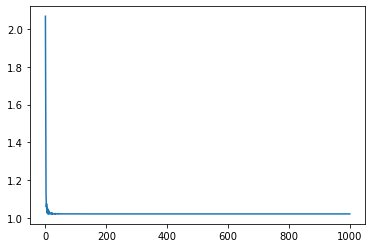

In [90]:
iters = np.arange(0,test.grads.shape[0])
plt.plot(iters, test.obj_vals)

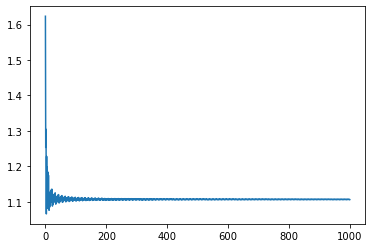

In [91]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, np.linalg.norm(test.grads, axis = 1))

In [92]:
test.c

array([0.54592008, 0.        , 0.45407992])

In [93]:
test.reset_values()
test.FW_Bures_routine()

g
G
[[-0.55001141 -0.42588768]
 [-0.42588768 -0.35596637]]
rho
[[[ 0.          0.        ]
  [ 0.          0.66666667]]

 [[ 0.         -0.16666667]
  [-0.16666667  0.        ]]

 [[ 0.          0.16666667]
  [ 0.16666667  0.        ]]]
[-1.45052092 -6.07494105 -3.75929405]
ga
[-1.41099691 -6.03568554 -3.71977091]
g
G
[[-0.29218607 -0.38028847]
 [-0.38028847  0.01511999]]
rho
[[[ 0.  -0.5]
  [-0.5  0. ]]

 [[ 0.5  0. ]
  [ 0.   0. ]]

 [[-0.5  0. ]
  [ 0.   0. ]]]
[-1.02252302 -1.77641889 -2.11822078]
ga
[-0.94945431 -1.70358419 -2.04504728]
g
G
[[-0.36798359 -0.38516403]
 [-0.38516403 -0.32358116]]
rho
[[[ 0.          0.16666667]
  [ 0.16666667  0.        ]]

 [[-0.16666667  0.        ]
  [ 0.          0.        ]]

 [[ 0.16666667  0.        ]
  [ 0.          0.        ]]]
[-1.27192194 -4.75902584 -2.92009006]
ga
[-1.26177073 -4.74898815 -2.90989876]
g
G
[[-0.31321708 -0.38550463]
 [-0.38550463 -0.11369925]]
rho
[[[ 0.         -0.16666667]
  [-0.16666667  0.        ]]

 [[ 0.16666667 

ga
[-0.98725557 -2.20514536 -2.18052864]
g
G
[[-0.29829026 -0.38281311]
 [-0.38281311 -0.03814858]]
rho
[[[ 0.         -0.34537815]
  [-0.34537815  0.        ]]

 [[ 0.34537815  0.        ]
  [ 0.          0.        ]]

 [[-0.34537815  0.        ]
  [ 0.          0.        ]]]
[-1.0218311  -2.22769803 -2.21267991]
ga
[-0.98615885 -2.19233036 -2.1769762 ]
g
G
[[-0.29807862 -0.38275434]
 [-0.38275434 -0.0367979 ]]
rho
[[[ 0.         -0.34897401]
  [-0.34897401  0.        ]]

 [[ 0.34897401  0.        ]
  [ 0.          0.        ]]

 [[-0.34897401  0.        ]
  [ 0.          0.        ]]]
[-1.0215714  -2.21605704 -2.20996033]
ga
[-0.98524094 -2.18003988 -2.17357874]
g
G
[[-0.2978775  -0.38269754]
 [-0.38269754 -0.03549935]]
rho
[[[ 0.         -0.35244587]
  [-0.35244587  0.        ]]

 [[ 0.35244587  0.        ]
  [ 0.          0.        ]]

 [[-0.35244587  0.        ]
  [ 0.          0.        ]]]
[-1.02133406 -2.20487339 -2.20735883]
ga
[-0.98419189 -2.16809511 -2.17024088]
g
G
[[-0.29

[[-0.2980339  -0.38274179]
 [-0.38274179 -0.03651044]]
rho
[[[ 0.         -0.34974132]
  [-0.34974132  0.        ]]

 [[ 0.34974132  0.        ]
  [ 0.          0.        ]]

 [[-0.34974132  0.        ]
  [ 0.          0.        ]]]
[-1.02151782 -2.21358066 -2.20938333]
ga
[-0.9849906  -2.17730999 -2.1728158 ]
g
G
[[-0.297929   -0.38271217]
 [-0.38271217 -0.03583328]]
rho
[[[ 0.         -0.35155166]
  [-0.35155166  0.        ]]

 [[ 0.35155166  0.        ]
  [ 0.          0.        ]]

 [[-0.35155166  0.        ]
  [ 0.          0.        ]]]
[-1.02139394 -2.20774861 -2.20802659]
ga
[-0.98448992 -2.17117071 -2.17107534]
g
G
[[-0.29853114 -0.38287881]
 [-0.38287881 -0.03966734]]
rho
[[[ 0.         -0.34135344]
  [-0.34135344  0.        ]]

 [[ 0.34135344  0.        ]
  [ 0.          0.        ]]

 [[-0.34135344  0.        ]
  [ 0.          0.        ]]]
[-1.02213862 -2.24079769 -2.21575428]
ga
[-0.98735094 -2.20624208 -2.18089819]
g
G
[[-0.29841757 -0.38284799]
 [-0.38284799 -0.03895372

[[[ 0.         -0.35091381]
  [-0.35091381  0.        ]]

 [[ 0.35091381  0.        ]
  [ 0.          0.        ]]

 [[-0.35091381  0.        ]
  [ 0.          0.        ]]]
[-1.02143718 -2.20980177 -2.20850388]
ga
[-0.98463297 -2.17330456 -2.17165947]
g
G
[[-0.29789783 -0.38270332]
 [-0.38270332 -0.03563132]]
rho
[[[ 0.         -0.35209235]
  [-0.35209235  0.        ]]

 [[ 0.35209235  0.        ]
  [ 0.          0.        ]]

 [[-0.35209235  0.        ]
  [ 0.          0.        ]]]
[-1.02135763 -2.20600965 -2.20762263]
ga
[-0.98443031 -2.16937065 -2.17065811]
g
G
[[-0.29828997 -0.38281303]
 [-0.38281303 -0.03814677]]
rho
[[[ 0.         -0.34538296]
  [-0.34538296  0.        ]]

 [[ 0.34538296  0.        ]
  [ 0.          0.        ]]

 [[-0.34538296  0.        ]
  [ 0.          0.        ]]]
[-1.02183074 -2.22768241 -2.21267625]
ga
[-0.98631382 -2.19234228 -2.17704773]
g
G
[[-0.29821822 -0.38279322]
 [-0.38279322 -0.03769061]]
rho
[[[ 0.         -0.34659565]
  [-0.34659565  0.      

[[[ 0.         -0.34726262]
  [-0.34726262  0.        ]]

 [[ 0.34726262  0.        ]
  [ 0.          0.        ]]

 [[-0.34726262  0.        ]
  [ 0.          0.        ]]]
[-1.02169324 -2.22158999 -2.21125147]
ga
[-0.98568201 -2.1858573  -2.17522383]
g
G
[[-0.29812441 -0.38276714]
 [-0.38276714 -0.03709147]]
rho
[[[ 0.         -0.34819112]
  [-0.34819112  0.        ]]

 [[ 0.34819112  0.        ]
  [ 0.          0.        ]]

 [[-0.34819112  0.        ]
  [ 0.          0.        ]]]
[-1.02162674 -2.21858649 -2.21055025]
ga
[-0.98540783 -2.18267441 -2.17422247]
g
G
[[-0.29807062 -0.3827521 ]
 [-0.3827521  -0.0367465 ]]
rho
[[[ 0.         -0.34911117]
  [-0.34911117  0.        ]]

 [[ 0.34911117  0.        ]
  [ 0.          0.        ]]

 [[-0.34911117  0.        ]
  [ 0.          0.        ]]]
[-1.02156178 -2.21561417 -2.2098571 ]
ga
[-0.98519325 -2.17950344 -2.17344761]
g
G
[[-0.29801753 -0.38273719]
 [-0.38273719 -0.03640502]]
rho
[[[ 0.         -0.35002289]
  [-0.35002289  0.      

[-1.02164787 -2.21954496 -2.21077394]
ga
[-0.9855032  -2.18369961 -2.17460394]
g
G
[[-0.29809823 -0.38275983]
 [-0.38275983 -0.03692369]]
rho
[[[ 0.         -0.34863848]
  [-0.34863848  0.        ]]

 [[ 0.34863848  0.        ]
  [ 0.          0.        ]]

 [[-0.34863848  0.        ]
  [ 0.          0.        ]]]
[-1.02159504 -2.21714077 -2.21021301]
ga
[-0.98538399 -2.18113661 -2.17387676]
g
G
[[-0.29805513 -0.38274775]
 [-0.38274775 -0.03664696]]
rho
[[[ 0.         -0.34937683]
  [-0.34937683  0.        ]]

 [[ 0.34937683  0.        ]
  [ 0.          0.        ]]

 [[-0.34937683  0.        ]
  [ 0.          0.        ]]]
[-1.02154319 -2.21475667 -2.20965727]
ga
[-0.98509789 -2.17862129 -2.17316151]
g
G
[[-0.29801248 -0.38273576]
 [-0.38273576 -0.0363725 ]]
rho
[[[ 0.         -0.35010979]
  [-0.35010979  0.        ]]

 [[ 0.35010979  0.        ]
  [ 0.          0.        ]]

 [[-0.35010979  0.        ]
  [ 0.          0.        ]]]
[-1.02149231 -2.21239242 -2.20910666]
ga
[-0.9849309

ga
[-0.98524094 -2.1802187  -2.17363834]
g
G
[[-0.29804763 -0.38274565]
 [-0.38274565 -0.03659878]]
rho
[[[ 0.         -0.34950545]
  [-0.34950545  0.        ]]

 [[ 0.34950545  0.        ]
  [ 0.          0.        ]]

 [[-0.34950545  0.        ]
  [ 0.          0.        ]]]
[-1.02153422 -2.21434161 -2.20956057]
ga
[-0.98512173 -2.17820406 -2.17303038]
g
G
[[-0.29801198 -0.38273562]
 [-0.38273562 -0.03636925]]
rho
[[[ 0.         -0.35011846]
  [-0.35011846  0.        ]]

 [[ 0.35011846  0.        ]
  [ 0.          0.        ]]

 [[-0.35011846  0.        ]
  [ 0.          0.        ]]]
[-1.02149172 -2.21236446 -2.20910015]
ga
[-0.98488331 -2.17607021 -2.17251778]
g
G
[[-0.29797664 -0.38272565]
 [-0.38272565 -0.03614129]]
rho
[[[ 0.         -0.35072773]
  [-0.35072773  0.        ]]

 [[ 0.35072773  0.        ]
  [ 0.          0.        ]]

 [[-0.35072773  0.        ]
  [ 0.          0.        ]]]
[-1.02144987 -2.21040105 -2.20864327]
ga
[-0.98475218 -2.17388868 -2.1718502 ]
g
G
[[-0.29

G
[[-0.29798336 -0.38272755]
 [-0.38272755 -0.03618468]]
rho
[[[ 0.         -0.35061174]
  [-0.35061174  0.        ]]

 [[ 0.35061174  0.        ]
  [ 0.          0.        ]]

 [[-0.35061174  0.        ]
  [ 0.          0.        ]]]
[-1.02145781 -2.21077473 -2.20873019]
ga
[-0.9848237  -2.17437744 -2.17194557]
g
G
[[-0.29795317 -0.38271902]
 [-0.38271902 -0.03598969]]
rho
[[[ 0.         -0.35113316]
  [-0.35113316  0.        ]]

 [[ 0.35113316  0.        ]
  [ 0.          0.        ]]

 [[-0.35113316  0.        ]
  [ 0.          0.        ]]]
[-1.02142226 -2.20909549 -2.20833965]
ga
[-0.98477602 -2.17267275 -2.17155218]
g
G
[[-0.29792322 -0.38271053]
 [-0.38271053 -0.03579585]]
rho
[[[ 0.         -0.35165186]
  [-0.35165186  0.        ]]

 [[ 0.35165186  0.        ]
  [ 0.          0.        ]]

 [[-0.35165186  0.        ]
  [ 0.          0.        ]]]
[-1.02138718 -2.20742625 -2.20795168]
ga
[-0.9845376  -2.1707654  -2.17097998]
g
G
[[-0.29809524 -0.38275899]
 [-0.38275899 -0.036904

  [ 0.          0.        ]]]
[-1.021403   -2.20818075 -2.20812702]
ga
[-0.98459721 -2.17161179 -2.17123032]
g
G
[[-0.29791058 -0.38270695]
 [-0.38270695 -0.03571397]]
rho
[[[ 0.         -0.35187105]
  [-0.35187105  0.        ]]

 [[ 0.35187105  0.        ]
  [ 0.          0.        ]]

 [[-0.35187105  0.        ]
  [ 0.          0.        ]]]
[-1.02137245 -2.20672125 -2.2077879 ]
ga
[-0.98450184 -2.17009783 -2.17084885]
g
G
[[-0.29806113 -0.38274944]
 [-0.38274944 -0.03668553]]
rho
[[[ 0.         -0.34927388]
  [-0.34927388  0.        ]]

 [[ 0.34927388  0.        ]
  [ 0.          0.        ]]

 [[-0.34927388  0.        ]
  [ 0.          0.        ]]]
[-1.02155038 -2.21508893 -2.20973469]
ga
[-0.98509789 -2.17888355 -2.17322111]
g
G
[[-0.2980344  -0.38274193]
 [-0.38274193 -0.03651367]]
rho
[[[ 0.         -0.34973271]
  [-0.34973271  0.        ]]

 [[ 0.34973271  0.        ]
  [ 0.          0.        ]]

 [[-0.34973271  0.        ]
  [ 0.          0.        ]]]
[-1.02151842 -2.213608

[-1.02149153 -2.21235575 -2.20909812]
ga
[-0.98481178 -2.17593908 -2.17241049]
g
G
[[-0.29798828 -0.38272894]
 [-0.38272894 -0.03621646]]
rho
[[[ 0.         -0.35052679]
  [-0.35052679  0.        ]]

 [[ 0.35052679  0.        ]
  [ 0.          0.        ]]

 [[-0.35052679  0.        ]
  [ 0.          0.        ]]]
[-1.02146363 -2.21104842 -2.20879387]
ga
[-0.98481178 -2.17462778 -2.17208862]
g
G
[[-0.29796488 -0.38272233]
 [-0.38272233 -0.03606536]]
rho
[[[ 0.         -0.35093077]
  [-0.35093077  0.        ]]

 [[ 0.35093077  0.        ]
  [ 0.          0.        ]]

 [[-0.35093077  0.        ]
  [ 0.          0.        ]]]
[-1.02143602 -2.20974714 -2.20849118]
ga
[-0.98469257 -2.17323303 -2.17169523]
g
G
[[-0.29794162 -0.38271575]
 [-0.38271575 -0.03591495]]
rho
[[[ 0.         -0.35133311]
  [-0.35133311  0.        ]]

 [[ 0.35133311  0.        ]
  [ 0.          0.        ]]

 [[-0.35133311  0.        ]
  [ 0.          0.        ]]]
[-1.0214087  -2.20845187 -2.20819003]
ga
[-0.9846091

ga
[-0.98474026 -2.17373371 -2.17183828]
g
G
[[-0.29795213 -0.38271873]
 [-0.38271873 -0.03598295]]
rho
[[[ 0.         -0.35115118]
  [-0.35115118  0.        ]]

 [[ 0.35115118  0.        ]
  [ 0.          0.        ]]

 [[-0.35115118  0.        ]
  [ 0.          0.        ]]]
[-1.02142103 -2.20903747 -2.20832616]
ga
[-0.98470449 -2.1725893  -2.17155218]
g
G
[[-0.29793121 -0.3827128 ]
 [-0.3827128  -0.0358476 ]]
rho
[[[ 0.         -0.35151335]
  [-0.35151335  0.        ]]

 [[ 0.35151335  0.        ]
  [ 0.          0.        ]]

 [[-0.35151335  0.        ]
  [ 0.          0.        ]]]
[-1.02139652 -2.20787188 -2.20805523]
ga
[-0.98451376 -2.1712184  -2.17109919]
g
G
[[-0.29805121 -0.38274665]
 [-0.38274665 -0.03662178]]
rho
[[[ 0.         -0.34944406]
  [-0.34944406  0.        ]]

 [[ 0.34944406  0.        ]
  [ 0.          0.        ]]

 [[-0.34944406  0.        ]
  [ 0.          0.        ]]]
[-1.0215385  -2.21453971 -2.20960672]
ga
[-0.98506212 -2.17825174 -2.17308998]
g
G
[[-0.29

[[[ 0.         -0.35109209]
  [-0.35109209  0.        ]]

 [[ 0.35109209  0.        ]
  [ 0.          0.        ]]

 [[-0.35109209  0.        ]
  [ 0.          0.        ]]]
[-1.02142505 -2.2092277  -2.20837039]
ga
[-0.98464489 -2.1727562  -2.17155218]
g
G
[[-0.29793661 -0.38271433]
 [-0.38271433 -0.03588258]]
rho
[[[ 0.         -0.35141972]
  [-0.35141972  0.        ]]

 [[ 0.35141972  0.        ]
  [ 0.          0.        ]]

 [[-0.35141972  0.        ]
  [ 0.          0.        ]]]
[-1.02140284 -2.20817314 -2.20812525]
ga
[-0.98454952 -2.17149258 -2.17117071]
g
G
[[-0.29791777 -0.38270899]
 [-0.38270899 -0.03576057]]
rho
[[[ 0.         -0.35174627]
  [-0.35174627  0.        ]]

 [[ 0.35174627  0.        ]
  [ 0.          0.        ]]

 [[-0.35174627  0.        ]
  [ 0.          0.        ]]]
[-1.02138083 -2.20712255 -2.20788112]
ga
[-0.98444223 -2.17045546 -2.17087269]
g
G
[[-0.29802605 -0.38273958]
 [-0.38273958 -0.03645988]]
rho
[[[ 0.         -0.34987636]
  [-0.34987636  0.      

ga
[-0.98459721 -2.17212439 -2.17144489]
g
G
[[-0.29792916 -0.38271222]
 [-0.38271222 -0.03583433]]
rho
[[[ 0.         -0.35154886]
  [-0.35154886  0.        ]]

 [[ 0.35154886  0.        ]
  [ 0.          0.        ]]

 [[-0.35154886  0.        ]
  [ 0.          0.        ]]]
[-1.02139412 -2.20775763 -2.20802869]
ga
[-0.98454952 -2.17113495 -2.17115879]
g
G
[[-0.29802873 -0.38274034]
 [-0.38274034 -0.03647713]]
rho
[[[ 0.         -0.34983029]
  [-0.34983029  0.        ]]

 [[ 0.34983029  0.        ]
  [ 0.          0.        ]]

 [[-0.34983029  0.        ]
  [ 0.          0.        ]]]
[-1.02151165 -2.21329367 -2.20931649]
ga
[-0.98495483 -2.17696428 -2.17270851]
g
G
[[-0.29801113 -0.38273538]
 [-0.38273538 -0.03636379]]
rho
[[[ 0.         -0.35013305]
  [-0.35013305  0.        ]]

 [[ 0.35013305  0.        ]
  [ 0.          0.        ]]

 [[-0.35013305  0.        ]
  [ 0.          0.        ]]]
[-1.02149071 -2.21231741 -2.20908919]
ga
[-0.98491907 -2.17603445 -2.17248201]
g
G
[[-0.29

In [94]:
test.c

array([0.        , 0.85082517, 0.14917483])

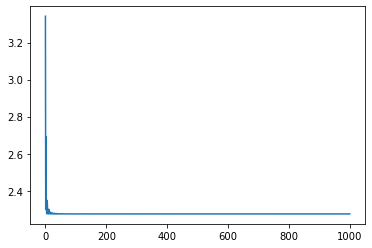

In [95]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, test.obj_vals)


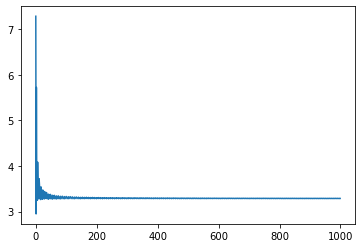

In [96]:
iters = np.arange(0, test.grads.shape[0])
plt.plot(iters, np.linalg.norm(test.grads, axis=1))


In [97]:
test.c

array([0.        , 0.85082517, 0.14917483])